#DeepLift

This Jupyter Notebook code imports necessary libraries including torch, torchvision, PIL, and Captum for the task of visualizing the attribution map of an input image using the DeepLift attribution method.

Firstly, the VGG16 model pretrained on the ImageNet dataset is loaded and set to evaluation mode.

Next, a transform is defined for the input image which resizes it to 224x224 pixels and converts it to a tensor. Additionally, another transform is defined to normalize the tensor values using mean and standard deviation values specific to the ImageNet dataset.

An image is loaded using PIL and transformed using the defined transforms. The resulting tensor is normalized using the defined normalization transform and unsqueezed to add an extra dimension for batch size.

Then, a baseline is defined for DeepLift as a tensor with the same shape as the input image tensor but filled with zeros.

The DeepLift attribution method is defined with the loaded VGG16 model.

Finally, the attribution map is computed using DeepLift with the input image and baseline. The target class is set to the class with the highest predicted probability for the input image. The resulting attribution map is converted to a NumPy array and transposed to match the format expected by the visualization function in Captum.

This Jupyter notebook is based on:

*   https://captum.ai/tutorials/CIFAR_TorchVision_Interpret
*   https://captum.ai/docs/attribution_algorithms#deeplift
*   https://www.youtube.com/playlist?list=PLJLjQOkqSRTP3cLB2cOOi_bQFw6KPGKML
*   https://openreview.net/pdf?id=Sy21R9JAW
*   https://arxiv.org/abs/1704.02685

#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [2]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [1]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Using DeepLift

This code loads a pretrained VGG16 model and uses the Captum library to compute an attribution map for an input image using the DeepLift method. The input image is first transformed using torchvision transforms, then normalized and processed to generate the attribution map. Finally, the attribution map is visualized using Captum's visualization tools and displayed using matplotlib.

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import visualization as viz
from captum.attr import DeepLift, visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F

# Load the model and set it to evaluation mode
model = models.vgg16(pretrained=True)
model.eval()

# Define the transforms for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/stop_traffic_sign.jpg')

transformed_img = transform(img)

input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0)

# Define the baseline for DeepLift
baseline = torch.zeros_like(input_img)

# Define the DeepLift attribution method
dl = DeepLift(model)

# Compute the attribution map using DeepLift
target = torch.argmax(model(input_img))
print (target)

# Make predictions with the model
outputs = model(input_img)
output_probs = F.softmax(outputs, dim=1).squeeze(0)
# Find the index of the maximum value
label_idx = output_probs.argmax()
# Get the corresponding probability
probability = output_probs[label_idx].item() * 100 # converting to percentage
print(f"Label Index: {label_idx}, Probability: {probability:.2f}%")

attr_dl = dl.attribute(input_img, baseline, target=target)

attr_np = np.transpose(attr_dl.squeeze().cpu().detach().numpy(), (1,2,0))

tensor(919)
Label Index: 919, Probability: 98.42%


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


#### XAI metrics

A low infidelity value close to 0 indicates that the explanation provided by the XAI method is relatively faithful to the model's behavior. It suggests that the generated explanation is a good representation of how the model arrived at its predictions, making it a reliable and accurate explanation.

A high sensitivity value indicates that the model is highly sensitive to changes in specific input features. In other words, small changes in those features can lead to substantial changes in the model's predictions. This suggests that the model heavily relies on the identified features to make its decisions.

In [ ]:
from captum.metrics import infidelity, sensitivity_max

# Define the perturbation function
def perturb_fn(inputs):
    # Multiplying by 0.003 scales the random values to control the magnitude of the perturbations.
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
    return noise, inputs - noise

# Compute the infidelity
infid = infidelity(model, perturb_fn, input_img, attr_dl, target=target)

print(f"Infidelity: {infid.item()}")

# Wrapper function for dl.attribute
def dl_attr(inputs):
    return dl.attribute(inputs, baseline, target=target)

# Calculate Sensitivity
sens = sensitivity_max(dl_attr, input_img)
print(f"Sensitivity: {sens.item()}")

Infidelity: 0.0007737121777608991
Sensitivity: 0.6115794777870178


#### Visualization

Display the input image and its attribution map using a heatmap color scheme in a single plot.

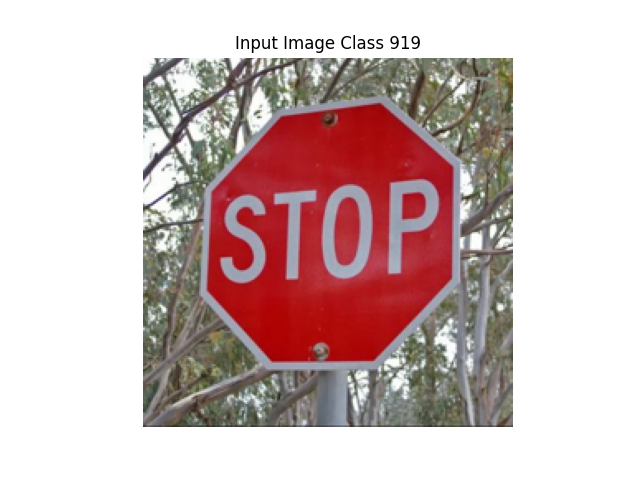

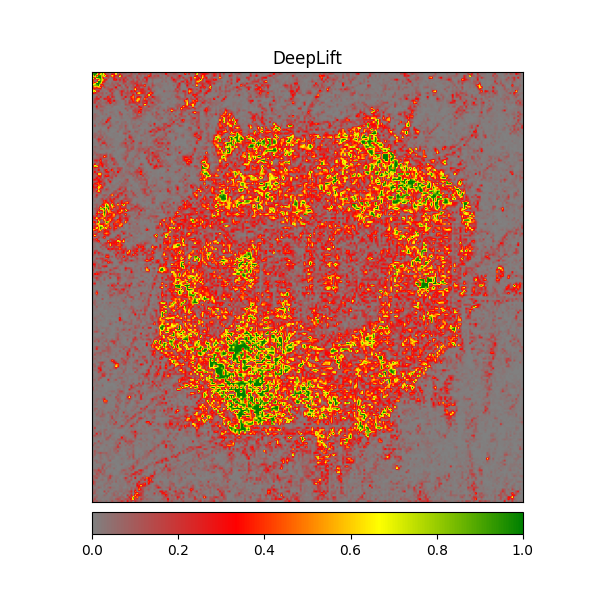

In [ ]:
# Display the input image on the first subplot
input_img_np = np.transpose(transformed_img, (1, 2, 0))
plt.axis('off')
plt.imshow(img.resize((224, 224)))
plt.title(f'Input Image Class {target}')

# Adjust the color map scale to highlight attribution values
cmap = LinearSegmentedColormap.from_list('custom', ['gray', 'red', 'yellow', 'green'], N=256)
_ = viz.visualize_image_attr(attr_np, method='heat_map', cmap=cmap, alpha_overlay=0.2, show_colorbar=True, sign='absolute_value', outlier_perc=20, title='DeepLift')

plt.show()